In [ ]:
! pip install mne
! pip install pyriemann

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 7.5 MB 6.7 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 365 kB 32.2 MB/s 
  Created wheel for pyriemann: filename=pyriemann-0.3-py2.py3-none-any.whl size=78033 sha256=faf653b99726585e5ad2a79cfee4eb32fd993d35ff9ee3df8adb58192e9ade72
  Stored in directory: /root/.cache/pip/wheels/0b/1b/bf/a537f9e17e6c3490004ede419c72f863af1d0d765d25e532ef
Successfully built pyriemann


In [ ]:
from scipy.io import loadmat
import numpy as np
import mne
import glob

google_path = '/content/drive/My Drive/Online/'

from google.colab import drive
drive.mount('/content/drive') 

data = loadmat("drive/My Drive/BR4IN.IO/ECoG_Handpose.mat", struct_as_record=True)

data_ = data["y"]
data_ecog = data_[1:60, :]
nchannels, nsamples = data_ecog.shape
label = data_[61, :]
sample_time = data_[1, :]

# Create MNE Structure
# Create Info
n_channels = 59
sfreq = 1200  # in Hertz
info = mne.create_info(n_channels, sfreq=sfreq, ch_types="ecog")

raw = mne.io.RawArray(data_ecog, info)
# raw.plot()
# raw.plot_psd(spatial_colors=True)


# Create Events, Exclude Relax
events = []
for i in np.arange(1, len(label)):
    if label[i-1] != label[i] and label[i] != 0:
        events.append((i, 0, int(label[i])))

events = np.array(events)

event_id = {
'Fist': 1,
'Peace': 2,
'Open': 3,
}

# raw.plot(events=events, event_id=event_id)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Creating RawArray with float64 data, n_channels=59, n_times=507025
    Range : 0 ... 507024 =      0.000 ...   422.520 secs
Ready.


In [ ]:
# ====================================================================================================================
# REREFERENCING by COMMON AVERAGE
# ====================================================================================================================
referenced_raw, _ = mne.set_eeg_reference(raw, ref_channels="average", copy=True, ch_type="ecog")
# referenced_raw.plot(events=events, event_id=event_id)
# referenced_raw.plot_psd()

Applying average reference.
Applying a custom ('ECoG',) reference.


In [ ]:
# ====================================================================================================================
# NOTCH FILTER
# ====================================================================================================================
# Remove power line artifact (visible from psd visualization)
iir_params = dict(order=6, ftype='butter', output='sos')
raw_notch0 = referenced_raw.copy().notch_filter(freqs=50, method='iir', iir_params=iir_params)
raw_notch1 = raw_notch0.copy().notch_filter(freqs=100, method='iir', iir_params=iir_params)
raw_notch2 = raw_notch1.copy().notch_filter(freqs=150, method='iir', iir_params=iir_params)
raw_notch3 = raw_notch2.copy().notch_filter(freqs=200, method='iir', iir_params=iir_params)
raw_notch4 = raw_notch3.copy().notch_filter(freqs=250, method='iir', iir_params=iir_params)
raw_notch = raw_notch4.copy().notch_filter(freqs=300, method='iir', iir_params=iir_params)

# Plot PSD
# raw_notch.plot(events=events, event_id=event_id)
# raw_notch.plot_psd()

Setting up band-stop filter from 49 - 51 Hz

IIR filter parameters
---------------------
Butterworth bandstop zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 24 (effective, after forward-backward)
- Cutoffs at 49.38, 50.62 Hz: -6.02, -6.02 dB

Setting up band-stop filter from 99 - 1e+02 Hz

IIR filter parameters
---------------------
Butterworth bandstop zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 24 (effective, after forward-backward)
- Cutoffs at 99.25, 100.75 Hz: -6.02, -6.02 dB

Setting up band-stop filter from 1.5e+02 - 1.5e+02 Hz

IIR filter parameters
---------------------
Butterworth bandstop zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 24 (effective, after forward-backward)
- Cutoffs at 149.12, 150.88 Hz: -6.02, -6.02 dB

Setting up band-stop filter from 2e+02 - 2e+02 Hz

IIR filter parameters
---------------------
Butterworth bandstop zero-phase (two-pass forward and reverse) non-causal

In [ ]:
# ====================================================================================================================
# BAND-PASS FILTER
# ====================================================================================================================
# Inspect data
# raw.plot()
# filt_low, filt_high = 6, 14
filt_low, filt_high = 50, 300
# Apply band_pass filter
iir_params = dict(order=6, ftype='butter', output='sos')
raw_bandpass = raw_notch.copy().filter(l_freq=filt_low, h_freq=filt_high, method="iir")
# raw_bandpass.plot()
# raw_bandpass.plot_psd(spatial_colors=True)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 50 - 3e+02 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 50.00, 300.00 Hz: -6.02, -6.02 dB



In [ ]:
# ====================================================================================================================
# EPOCH
# ====================================================================================================================
# Epoch starts 0.3 seconds before events and end 0.5 second after the events
t_min = 0
t_max = .7

# Create the Epoch
epochs = mne.Epochs(raw_bandpass,
                    events=events,
                    event_id=event_id,
                    tmin=t_min,
                    tmax=t_max,
                    baseline=None,
                    preload=True)

# Plot
# epochs.plot(events=events)

Not setting metadata
90 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 90 events and 841 original time points ...
0 bad epochs dropped


In [ ]:
# ====================================================================================================================
# CREATION DATASET
# ====================================================================================================================
# Create the X and y dataset
X = epochs.get_data()
y = epochs.events[:, -1]

#np.save('drive/My Drive/BR4IN.IO/X.npy',X)
#np.save('drive/My Drive/BR4IN.IO/y.npy',y)

In [ ]:
# ====================================================================================================================
# SPECTRAL WHITENING
# ====================================================================================================================
from scipy import signal
from mne.time_frequency import fit_iir_model_raw
order = 10  # define model order

# Estimate AR models on raw data
b, a = fit_iir_model_raw(raw_bandpass, order=order)

for i in np.arange(X.shape[0]):
    for j in np.arange(X.shape[1]):
        d = X[i][j, :]  # look at one channel from now on
        d = d.ravel()  # make flat vector
        innovation = signal.convolve(d, a, 'valid')
        d_ = signal.lfilter(b, a, innovation)  # regenerate the signal
        d_ = np.r_[d_[0] * np.ones(order), d_]  # dummy samples to keep signal length
        X[i][j, :] = d_

In [ ]:
def delete_some_class (X, Y, labels_to_drop):    
    for i in range(len(labels_to_drop)):
        curr_label = labels_to_drop[i];
        X.drop(Y.loc[Y['label']==curr_label].index, inplace=True)
        Y.drop(Y.loc[Y['label']==curr_label].index, inplace=True)
        
    X = X.reset_index(drop=True)
    Y = Y.reset_index(drop=True)

    return X, Y

In [ ]:
# ====================================================================================================================
## Classification MDM
# ====================================================================================================================
from pyriemann.classification import MDM
from pyriemann.estimation import Covariances
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline

cv = KFold(n_splits=10, shuffle=True, random_state=42)

# Classifier to test
clf = Pipeline(steps=[
                    ("Covariances", Covariances("lwf")),
                    ("MDM", MDM(metric=dict(mean='riemann', distance='riemann')))
])

# Use scikit-learn Pipeline with cross_val_score function
scores = cross_val_score(clf, X, y, cv=cv, n_jobs=1, scoring="accuracy")

print("Classification accuracy: %.3f +/- %.3f" %(np.mean(scores), np.std(scores)))

Classification accuracy: 0.744 +/- 0.100


In [ ]:
X_arr = np.array(X)
y_arr = np.array(y)

              precision    recall  f1-score   support

           1       0.97      1.00      0.98        30
           2       1.00      0.97      0.98        30
           3       0.97      0.97      0.97        30

    accuracy                           0.98        90
   macro avg       0.98      0.98      0.98        90
weighted avg       0.98      0.98      0.98        90

Accuracy score (Train): 9.777778e-01
              precision    recall  f1-score   support

           1       0.65      0.57      0.61        30
           2       0.62      0.70      0.66        30
           3       0.97      0.97      0.97        30

    accuracy                           0.74        90
   macro avg       0.75      0.74      0.74        90
weighted avg       0.75      0.74      0.74        90

Accuracy score (Test): 7.444444e-01
Classification accuracy: 0.744 +/- 0.100


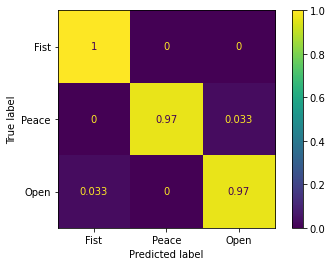

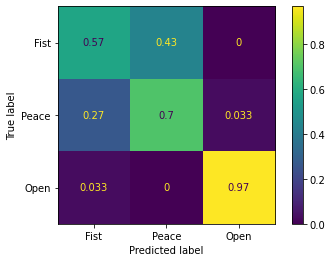

In [ ]:
# ====================================================================================================================
# Print Results
# ====================================================================================================================
import time
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, jaccard_score, hamming_loss

# Define Variable to save the Results
pred_train = np.zeros(len(y_arr))
pred_test = np.zeros(len(y_arr))

# Compute Starting Time
time_start = time.perf_counter()

for train_index, test_index in cv.split(X):
    #print(train_index.dtype)
    #print(test_index.dtype)
    train_index = train_index.astype(np.int32)
    test_index = test_index.astype(np.int32)
    X_train, X_test = X_arr[train_index], X_arr[test_index]
    y_train, y_test = y_arr[train_index], y_arr[test_index]

    y_train = y_train.ravel()
    y_test = y_test.ravel()
    
    # Fit the Model on the Training Dataset
    clf.fit(X_train, y_train)

    # Compute Y_pred using the MDM classifier on the Train Dataset
    pred_train[train_index] = clf.predict(X_train)

    # Compute Y_pred using the MDM classifier on the Test Dataset
    pred_test[test_index] = clf.predict(X_test)

# Compute Final Time of the Algorithm
time_elapsed = (time.perf_counter() - time_start)

# ===================================================================================================================
# Train Performances
# ===================================================================================================================
print(classification_report(y, pred_train))
print("Accuracy score (Train): {:e}".format(accuracy_score(y, pred_train)))

# Train Confusion Matrix
cm = confusion_matrix(y, pred_train, normalize='true')
ConfusionMatrixDisplay(cm, display_labels=['Fist', 'Peace', 'Open']).plot()

# ===================================================================================================================
# Test Performances
# ===================================================================================================================
print(classification_report(y, pred_test))
print("Accuracy score (Test): {:e}".format(accuracy_score(y, pred_test)))
print("Classification accuracy: %.3f +/- %.3f" %(np.mean(scores), np.std(scores)))

# Train Confusion Matrix
cm = confusion_matrix(y, pred_test, normalize='true')
ConfusionMatrixDisplay(cm, display_labels=['Fist', 'Peace', 'Open']).plot()

In [ ]:
# ====================================================================================================================
## SLIDING WINDOW APPROACH
# ====================================================================================================================
import pandas as pd
from sklearn.preprocessing import StandardScaler

X = pd.read_csv('drive/My Drive/BR4IN.IO/X_prep_data.csv')
y = pd.read_csv('drive/My Drive/BR4IN.IO/y_prep_data.csv')

scaler = StandardScaler()

X, y = delete_some_class(X.reset_index(drop=True), y.reset_index(drop=True), [0])

X = pd.DataFrame(scaler.fit_transform(X))

#y = y['label'].ravel()

In [ ]:
# ====================================================================================================================
## Classifier
# ====================================================================================================================
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

cv = KFold(n_splits=4, shuffle=True, random_state=0)

# Classifier to test
clf = Pipeline(steps=[
    ("SVM", SVC(C=10**2, gamma=10**-3, kernel='rbf'))
])

# Use scikit-learn Pipeline with cross_val_score function
scores = cross_val_score(clf, X, y, cv=cv, n_jobs=1, scoring="accuracy")

print("Classification accuracy: %.3f +/- %.3f" %(np.mean(scores), np.std(scores)))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Classification accuracy: 0.997 +/- 0.002


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
X_arr = np.array(X)
y_arr = np.array(y)

              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00       311
         2.0       1.00      1.00      1.00       315
         3.0       1.00      1.00      1.00       312

    accuracy                           1.00       938
   macro avg       1.00      1.00      1.00       938
weighted avg       1.00      1.00      1.00       938

Accuracy score (Train): 1.000000e+00
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00       311
         2.0       1.00      0.99      1.00       315
         3.0       0.99      1.00      1.00       312

    accuracy                           1.00       938
   macro avg       1.00      1.00      1.00       938
weighted avg       1.00      1.00      1.00       938

Accuracy score (Test): 9.968017e-01
Classification accuracy: 0.997 +/- 0.002


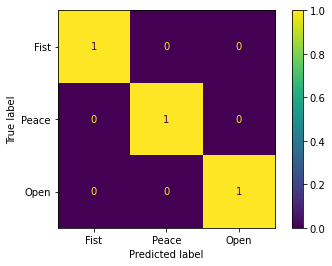

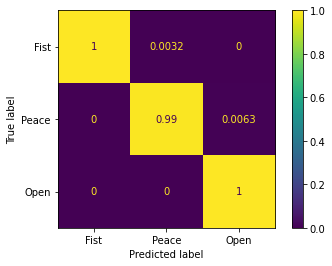

In [ ]:
# ====================================================================================================================
# Print Results
# ====================================================================================================================
import time
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, jaccard_score, hamming_loss

# Define Variable to save the Results
pred_train = np.zeros(len(y_arr))
pred_test = np.zeros(len(y_arr))

# Compute Starting Time
time_start = time.perf_counter()

for train_index, test_index in cv.split(X):
    #print(train_index.dtype)
    #print(test_index.dtype)
    train_index = train_index.astype(np.int32)
    test_index = test_index.astype(np.int32)
    X_train, X_test = X_arr[train_index], X_arr[test_index]
    y_train, y_test = y_arr[train_index], y_arr[test_index]

    y_train = y_train.ravel()
    y_test = y_test.ravel()
    
    # Fit the Model on the Training Dataset
    clf.fit(X_train, y_train)

    # Compute Y_pred using the MDM classifier on the Train Dataset
    pred_train[train_index] = clf.predict(X_train)

    # Compute Y_pred using the MDM classifier on the Test Dataset
    pred_test[test_index] = clf.predict(X_test)

# Compute Final Time of the Algorithm
time_elapsed = (time.perf_counter() - time_start)

# ===================================================================================================================
# Train Performances
# ===================================================================================================================
print(classification_report(y, pred_train))
print("Accuracy score (Train): {:e}".format(accuracy_score(y, pred_train)))

# Train Confusion Matrix
cm = confusion_matrix(y, pred_train, normalize='true')
ConfusionMatrixDisplay(cm, display_labels=['Fist', 'Peace', 'Open']).plot()

# ===================================================================================================================
# Test Performances
# ===================================================================================================================
print(classification_report(y, pred_test))
print("Accuracy score (Test): {:e}".format(accuracy_score(y, pred_test)))
print("Classification accuracy: %.3f +/- %.3f" %(np.mean(scores), np.std(scores)))

# Train Confusion Matrix
cm = confusion_matrix(y, pred_test, normalize='true')
ConfusionMatrixDisplay(cm, display_labels=['Fist', 'Peace', 'Open']).plot()